**Markovian exciton transfer model with dynamical system**

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider


Ode system

In [3]:
def markov_exciton_rhs(t, y, Delta_r, k_deph, k_loss1, k_loss2, k_relax):
    P1, P2, D, G = y

    dP1_dt = -Delta_r * P1 + Delta_r * P2 - (k_deph + k_loss1) * P1
    dP2_dt =  Delta_r * P1 - Delta_r * P2 - (k_deph + k_loss2) * P2
    dD_dt  =  k_deph * (P1 + P2) - k_relax * D
    dG_dt  =  k_loss1 * P1 + k_loss2 * P2 + k_relax * D

    return [dP1_dt, dP2_dt, dD_dt, dG_dt]


Diagrams

In [ ]:
                Δᵣ
     +---------------------------+
     |                           |
     v                           |
 [ X₁ ]  <--------------------> [ X₂ ]
   |  \                           /  |
   |   \ k_deph (dephasing)      /   |
   |    \                       /    |
 k_loss1 \                     / k_loss2
   |      \                   /      |
   v       v                 v       v
           [   D   ]   --->   [   G   ]
                k_relax      (ground-state sink)


Compartment meanings

X₁: Exciton on site 1

X₂: Exciton on site 2

D: Decohered excitation (incoherent excited state)

G: Ground state (loss/relaxation sink)

Rates

Δᵣ: renormalized coherent transfer rate

k_deph: dephasing → loss of coherence

k_loss1, k_loss2: population decay from each site

k_relax: decay from D → G

Intercative plotting function

In [4]:
def simulate_and_plot(Delta_r, k_deph, k_loss1, k_loss2, k_relax):
    # Initial conditions
    y0 = [1.0, 0.0, 0.0, 0.0]   # exciton starts on site 1

    # Time domain
    t_eval = np.linspace(0, 20, 500)

    sol = solve_ivp(
        markov_exciton_rhs,
        (0, 20),
        y0,
        t_eval=t_eval,
        args=(Delta_r, k_deph, k_loss1, k_loss2, k_relax)
    )

    P1, P2, D, G = sol.y

    plt.figure(figsize=(8, 5))
    plt.plot(sol.t, P1, label="P1 (site 1)")
    plt.plot(sol.t, P2, label="P2 (site 2)")
    plt.plot(sol.t, D,  label="D (decohered)")
    plt.plot(sol.t, G,  label="G (ground)")
    plt.ylim(0, 1.05)

    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.title("Markovian Exciton Dynamics (Interactive)")
    plt.legend()
    plt.grid(True)
    plt.show()


Slider for physical control

In [5]:
interact(
    simulate_and_plot,

    Delta_r = FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1,
                          description='Δᵣ (coherent rate)'),

    k_deph = FloatSlider(value=0.2, min=0.0, max=2.0, step=0.05,
                         description='k_deph'),

    k_loss1 = FloatSlider(value=0.05, min=0.0, max=1.0, step=0.01,
                          description='k_loss1'),

    k_loss2 = FloatSlider(value=0.05, min=0.0, max=1.0, step=0.01,
                          description='k_loss2'),

    k_relax = FloatSlider(value=0.1, min=0.0, max=2.0, step=0.05,
                          description='k_relax')
);


interactive(children=(FloatSlider(value=1.0, description='Δᵣ (coherent rate)', max=5.0), FloatSlider(value=0.2…

**Non-markovian**

X₁ ↔ X₂ with rate Δᵣ

X₁ → M with rate k_mem

X₂ → M with rate k_mem

M → X₁ and X₂ with total rate f_back * γ_mem (split equally, so each gets ½ f_back γ_mem M in the ODEs)

M → D with rate (1 - f_back) γ_mem

X₁ → D, X₂ → D with rate k_deph

D → G with rate k_relax

X₁ → G with rate k_loss1

X₂ → G with rate k_loss2

In [ ]:
             Δᵣ
                +-----------------------+
                |                       |
                v                       |
          +----------+           +----------+
          |   X₁     |<--------->|    X₂    |
          | (P1)     |           |  (P2)    |
          +----------+           +----------+
            |   \  \               /   /  |
            |    \  \             /   /   |
  k_loss1   |     \  \ k_mem     /   /    |  k_loss2
 (decay)    v      v   \        /   v     v  (decay)
          +----------+   \    /   +----------+
          |    G     |<---\  /    |    M     |
          | (ground) |    \/     | (memory)  |
          +----------+    /\     +----------+
                           |  γ_mem
                           |  (decay)
                           |
                    +----------------+
                    |  split of γ_mem|
                    |                |
      backflow (fraction f_back)     |   leak to decohered
           returns to X₁, X₂         |   state D (1 - f_back)
                    |                |
                    v                v
          +----------------+   +-----------+
          | effective term |   |     D     |
          | 0.5 f_back γM  |   | (decohered|
          | → X₁ and X₂    |   |  excited) |
          +----------------+   +-----------+
                                        |
                         k_relax         |
                        (relaxation)     v
                                      +------+
                                      |  G   |
                                      +------+


Total population min, max: 0.9999999999999994 1.0


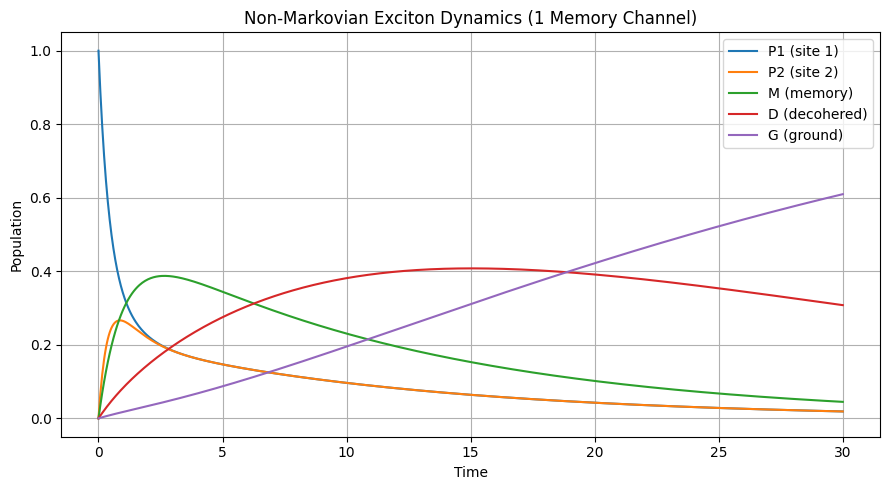

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


def nonmarkov_exciton_rhs(t, y,
                          Delta_r,
                          k_mem,
                          gamma_mem,
                          f_back,
                          k_deph,
                          k_loss1,
                          k_loss2,
                          k_relax):
    """
    Non-Markovian exciton model with one memory compartment.

    y = [P1, P2, M, D, G]
    """
    P1, P2, M, D, G = y

    # Backflow contribution from memory to each site (split equally here)
    backflow = 0.5 * f_back * gamma_mem * M

    # Exciton sites
    dP1_dt = (
        -Delta_r * P1 + Delta_r * P2
        - (k_deph + k_loss1 + k_mem) * P1
        + backflow
    )

    dP2_dt = (
        +Delta_r * P1 - Delta_r * P2
        - (k_deph + k_loss2 + k_mem) * P2
        + backflow
    )

    # Memory compartment
    dM_dt = k_mem * (P1 + P2) - gamma_mem * M

    # Decohered state
    dD_dt = k_deph * (P1 + P2) + (1.0 - f_back) * gamma_mem * M - k_relax * D

    # Ground state
    dG_dt = k_loss1 * P1 + k_loss2 * P2 + k_relax * D

    return [dP1_dt, dP2_dt, dM_dt, dD_dt, dG_dt]


def run_nonmarkov_sim():
    # ---- Parameters ----
    Delta_r   = 1.0    # coherent transfer rate
    k_mem     = 0.5    # rate into memory
    gamma_mem = 0.5    # memory decay rate
    f_back    = 0.9    # fraction of memory decay that flows back (non-Markovianity)

    k_deph  = 0.1      # dephasing into D
    k_loss1 = 0.02     # site 1 -> G
    k_loss2 = 0.02     # site 2 -> G
    k_relax = 0.05     # D -> G

    # ---- Initial conditions ----
    P1_0 = 1.0   # start with exciton on site 1
    P2_0 = 0.0
    M_0  = 0.0
    D_0  = 0.0
    G_0  = 0.0
    y0 = [P1_0, P2_0, M_0, D_0, G_0]

    # ---- Time grid ----
    t_start = 0.0
    t_end   = 30.0
    t_eval  = np.linspace(t_start, t_end, 800)

    # ---- Solve ODEs ----
    sol = solve_ivp(
        nonmarkov_exciton_rhs,
        t_span=(t_start, t_end),
        y0=y0,
        t_eval=t_eval,
        args=(Delta_r, k_mem, gamma_mem, f_back,
              k_deph, k_loss1, k_loss2, k_relax),
        rtol=1e-8,
        atol=1e-10
    )

    if not sol.success:
        print("ODE solver failed:", sol.message)

    t = sol.t
    P1, P2, M, D, G = sol.y

    # ---- Check population conservation ----
    total_pop = P1 + P2 + M + D + G
    print("Total population min, max:", total_pop.min(), total_pop.max())

    # ---- Plot populations ----
    plt.figure(figsize=(9, 5))
    plt.plot(t, P1, label="P1 (site 1)")
    plt.plot(t, P2, label="P2 (site 2)")
    plt.plot(t, M,  label="M (memory)")
    plt.plot(t, D,  label="D (decohered)")
    plt.plot(t, G,  label="G (ground)")

    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.title("Non-Markovian Exciton Dynamics (1 Memory Channel)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    run_nonmarkov_sim()


**Non markovian squeezed bath**

Compartmental diagrams

                         Δᵣ
          +-------------------------------------+
          |                                     |
          v                                     |
      [ X1 ] <-------------------------------> [ X2 ]
        |  \                                     /  |
        |   \ k_mem*V(p)                         /   |
        |    \                                   /    |
        v     v                                 v     v
      [ M_p ] [ memory p-channel ]       [ M_x ] [ memory x-channel ]
        |               \                  /              |
        | (γ_mem,fb_p)  \                /  (γ_mem,fb_x)  |
        v                \              /                 v
                          \            /
                            \        /
                             [   D   ] --k_relax--> [ G ]


1. Physical Model

We extend Model 2 by splitting memory into two channels:

p-quadrature memory
𝑀
𝑝
M
p
	​


x-quadrature memory
𝑀
𝑥
M
x
	​


Coupling strengths depend on squeezing:

𝑉
(
𝑝
)
=
1
4
(
𝑢
2
+
𝑤
2
−
2
𝑢
𝑤
cos
⁡
𝜃
)
,
𝑉
(
𝑥
)
=
1
4
(
𝑢
2
+
𝑤
2
+
2
𝑢
𝑤
cos
⁡
𝜃
)
V(p)=
4
1
	​

(u
2
+w
2
−2uwcosθ),V(x)=
4
1
	​

(u
2
+w
2
+2uwcosθ)

where

𝑢
=
cosh
⁡
𝑟
u=coshr

𝑤
=
sinh
⁡
𝑟
w=sinhr

𝑟
r = squeezing strength

𝜃
θ = squeezing angle

If θ ≈ 0 (p-squeezed), then:

𝑉
(
𝑝
)
V(p) small → weak noise → long coherence

𝑉
(
𝑥
)
V(x) large → strong noise → fast decoherence

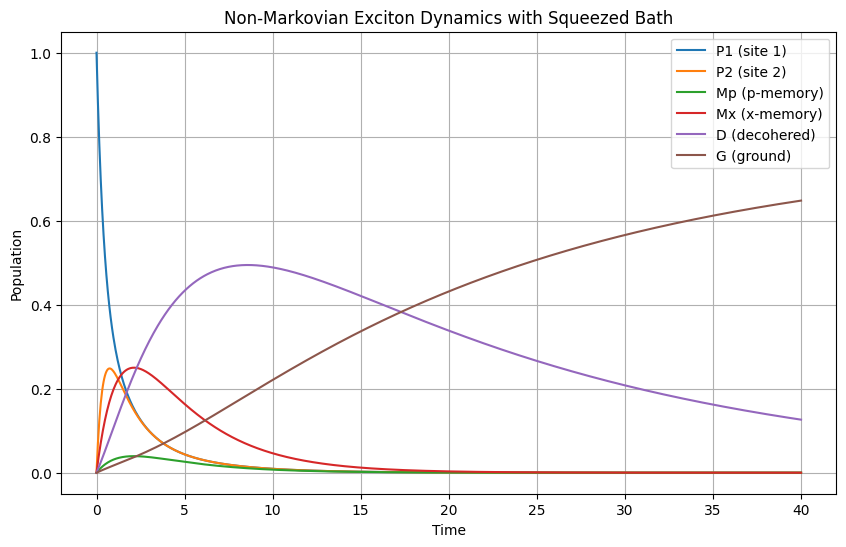

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


def squeezed_memory_exciton_rhs(t, y,
                                Delta_r,
                                k_mem,
                                gamma_mem,
                                r, theta,
                                f_p, f_x,
                                k_deph,
                                k_loss1,
                                k_loss2,
                                k_relax):
    """
    Model 3: Non-Markovian exciton dynamics with
    squeezed p- and x-channel memory compartments.

    y = [P1, P2, Mp, Mx, D, G]
    """

    P1, P2, Mp, Mx, D, G = y

    # Squeezing parameters
    u = np.cosh(r)
    w = np.sinh(r)

    # Quadrature variances
    Vp = 0.25 * (u*u + w*w - 2*u*w*np.cos(theta))
    Vx = 0.25 * (u*u + w*w + 2*u*w*np.cos(theta))

    # Backflow (split equally to P1/P2)
    backflow = 0.5 * (f_p * gamma_mem * Mp + f_x * gamma_mem * Mx)

    # Exciton populations
    dP1_dt = -Delta_r * P1 + Delta_r * P2 \
             - (k_deph + k_loss1 + k_mem) * P1 \
             + backflow

    dP2_dt =  Delta_r * P1 - Delta_r * P2 \
              - (k_deph + k_loss2 + k_mem) * P2 \
              + backflow

    # Memory channels
    dMp_dt = k_mem * Vp * (P1 + P2) - gamma_mem * Mp
    dMx_dt = k_mem * Vx * (P1 + P2) - gamma_mem * Mx

    # Decohered population
    dD_dt = k_deph * (P1 + P2) \
            + (1 - f_p) * gamma_mem * Mp \
            + (1 - f_x) * gamma_mem * Mx \
            - k_relax * D

    # Ground state
    dG_dt = k_loss1 * P1 + k_loss2 * P2 + k_relax * D

    return [dP1_dt, dP2_dt, dMp_dt, dMx_dt, dD_dt, dG_dt]


def run_squeezed_memory_sim():

    # ---- Physical parameters ----
    Delta_r   = 1.0        # coherent transfer
    k_mem     = 0.5        # rate into memory
    gamma_mem = 0.4        # decay of memory
    r         = 0.5        # squeezing strength
    theta     = 0.3        # squeezing angle

    f_p = 0.9              # p-channel backflow (strong)
    f_x = 0.2              # x-channel backflow (weak)

    k_deph  = 0.1
    k_loss1 = 0.02
    k_loss2 = 0.02
    k_relax = 0.05

    # ---- Initial conditions ----
    y0 = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # P1,P2,Mp,Mx,D,G

    # ---- Time domain ----
    t_eval = np.linspace(0, 40, 1000)

    # ---- Solve ----
    sol = solve_ivp(
        squeezed_memory_exciton_rhs,
        (0, 40),
        y0,
        t_eval=t_eval,
        args=(Delta_r, k_mem, gamma_mem, r, theta,
              f_p, f_x, k_deph, k_loss1, k_loss2, k_relax),
        rtol=1e-8, atol=1e-10
    )

    t = sol.t
    P1, P2, Mp, Mx, D, G = sol.y

    # ---- Plot ----
    plt.figure(figsize=(10, 6))
    plt.plot(t, P1, label="P1 (site 1)")
    plt.plot(t, P2, label="P2 (site 2)")
    plt.plot(t, Mp, label="Mp (p-memory)")
    plt.plot(t, Mx, label="Mx (x-memory)")
    plt.plot(t, D, label="D (decohered)")
    plt.plot(t, G, label="G (ground)")
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.title("Non-Markovian Exciton Dynamics with Squeezed Bath")
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    run_squeezed_memory_sim()
